In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor

from torchvision.models.efficientnet import FusedMBConvConfig,MBConvConfig,EfficientNet
from functools import partial
import numpy as np

In [39]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class MNISTDataset(Dataset):
    def __init__(self, csv_file, train=True):
        self.data = pd.read_csv(csv_file, header=None)
        self.train = train
        if train:
            self.data, _ = train_test_split(self.data, test_size=0.2, random_state=42)
        else:
            _, self.data = train_test_split(self.data, test_size=0.2, random_state=42)
        
        self.labels = self.data.iloc[:, 0]
        images = self.data.iloc[:, 1:].values
        new_images = []
        for idx in range(images.shape[0]):
          image = images[idx].astype('float32') / 255.0
          image_new = np.zeros((3, 28, 28)).astype('float32')
          for i in range(len(image)):
            image_new[0][i//28][i%28] = image[i]
            image_new[1][i//28][i%28] = image[i]
            image_new[2][i//28][i%28] = image[i]
          new_images.append(image_new)
        self.images = np.array(new_images)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels.values[idx]
        return image, label

train_dataset = MNISTDataset('/content/sample_data/mnist_train_small.csv', train=True)
test_dataset = MNISTDataset('/content/sample_data/mnist_test.csv', train=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(16000, 784)
(16000, 3, 28, 28)
(2000, 784)
(2000, 3, 28, 28)


In [40]:
learning_rate = 0.0001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
# default

inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 24, 2),
    FusedMBConvConfig(4, 3, 2, 24, 48, 4),
    FusedMBConvConfig(4, 3, 2, 48, 64, 4),
    MBConvConfig(4, 3, 2, 64, 128, 6),
    MBConvConfig(6, 3, 1, 128, 160, 9),
    MBConvConfig(6, 3, 2, 160, 256, 15),
]

model_default = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [42]:
# only using MBConv layers

inverted_residual_setting = [
    MBConvConfig(1, 3, 1, 24, 24, 2),
    MBConvConfig(4, 3, 2, 24, 48, 4),
    MBConvConfig(4, 3, 2, 48, 64, 4),
    MBConvConfig(4, 3, 2, 64, 128, 6),
    MBConvConfig(6, 3, 1, 128, 160, 9),
    MBConvConfig(6, 3, 2, 160, 256, 15),
]
model1 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [43]:
# only using FusedMBConv layers

inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 24, 2),
    FusedMBConvConfig(4, 3, 2, 24, 48, 4),
    FusedMBConvConfig(4, 3, 2, 48, 64, 4),
    FusedMBConvConfig(4, 3, 2, 64, 128, 6),
    FusedMBConvConfig(6, 3, 1, 128, 160, 9),
    FusedMBConvConfig(6, 3, 2, 160, 256, 15),
]
model2 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [44]:
# half the number of layers

inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 24, 1),
    FusedMBConvConfig(4, 3, 2, 24, 48, 2),
    FusedMBConvConfig(4, 3, 2, 48, 64, 2),
    MBConvConfig(4, 3, 2, 64, 128, 3),
    MBConvConfig(6, 3, 1, 128, 160, 4),
    MBConvConfig(6, 3, 2, 160, 256, 7),
]

model3 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [45]:
# dropped a config from recommmended


inverted_residual_setting = [
    FusedMBConvConfig(1, 3, 1, 24, 48, 2),
    FusedMBConvConfig(4, 3, 2, 48, 64, 4),
    MBConvConfig(4, 3, 2, 64, 128, 6),
    MBConvConfig(6, 3, 2, 128, 256, 15),
]

model4 = EfficientNet(inverted_residual_setting, 0.2, last_channel=1280, norm_layer=partial(nn.BatchNorm2d, eps=1e-03)).to(device)

In [46]:
ablation_models = [model_default, model1, model2, model3, model4]

In [48]:
results = [{"train":[], "test":[]} for m in ablation_models]

index = -1
for model in ablation_models:

  index += 1
  print("STARTING TRAINING FOR MODEL NUMBER", index)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  for epoch in range(5):
      # Training
      model.train()
      for i, (inputs, labels) in enumerate(train_loader):
          inputs, labels = inputs.to(device), labels.to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
      
      
      # Testing
      model.eval()
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, labels in train_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      results[index]["train"].append(correct/total)

      print('Epoch: {}, Training Accuracy: {:.2f}%'.format(epoch+1, 100*correct/total))
      
      correct = 0
      total = 0
      with torch.no_grad():
          for inputs, labels in test_loader:
              inputs, labels = inputs.to(device), labels.to(device)
              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      
      results[index]["test"].append(correct/total)

      print('Epoch: {}, Test Accuracy: {:.2f}%'.format(epoch+1, 100*correct/total))

STARTING TRAINING FOR MODEL NUMBER 0
Epoch: 1, Training Accuracy: 97.44%
Epoch: 1, Test Accuracy: 95.75%
Epoch: 2, Training Accuracy: 98.27%
Epoch: 2, Test Accuracy: 96.60%
Epoch: 3, Training Accuracy: 98.80%
Epoch: 3, Test Accuracy: 96.80%
Epoch: 4, Training Accuracy: 99.41%
Epoch: 4, Test Accuracy: 97.20%
Epoch: 5, Training Accuracy: 99.08%
Epoch: 5, Test Accuracy: 96.80%
STARTING TRAINING FOR MODEL NUMBER 1
Epoch: 1, Training Accuracy: 65.09%
Epoch: 1, Test Accuracy: 64.65%
Epoch: 2, Training Accuracy: 84.69%
Epoch: 2, Test Accuracy: 81.60%
Epoch: 3, Training Accuracy: 90.91%
Epoch: 3, Test Accuracy: 86.30%
Epoch: 4, Training Accuracy: 94.89%
Epoch: 4, Test Accuracy: 89.60%
Epoch: 5, Training Accuracy: 96.19%
Epoch: 5, Test Accuracy: 90.45%
STARTING TRAINING FOR MODEL NUMBER 2
Epoch: 1, Training Accuracy: 96.66%
Epoch: 1, Test Accuracy: 95.05%
Epoch: 2, Training Accuracy: 97.39%
Epoch: 2, Test Accuracy: 95.15%
Epoch: 3, Training Accuracy: 98.63%
Epoch: 3, Test Accuracy: 96.75%
Epoch

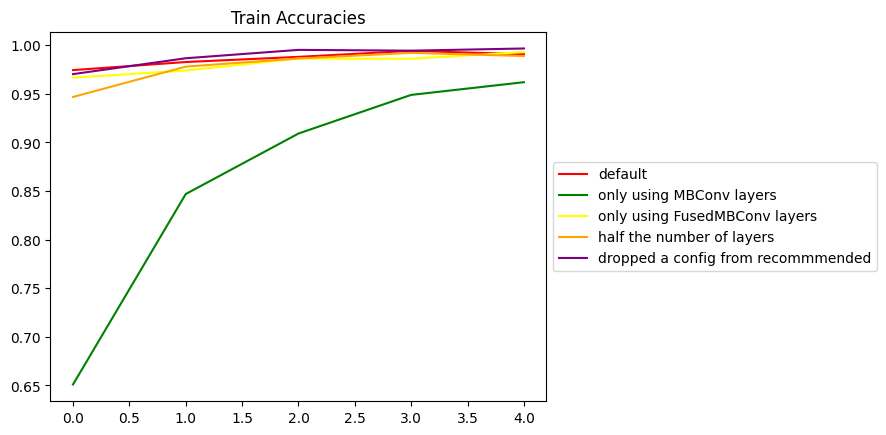

In [49]:
import numpy as np
import matplotlib.pyplot as plt

x = list(range(len(results[0]["train"])))

plt.plot(x, results[0]["train"], color='red', label='default')
plt.plot(x, results[1]["train"], color='green', label='only using MBConv layers')
plt.plot(x, results[2]["train"], color='yellow', label='only using FusedMBConv layers')
plt.plot(x, results[3]["train"], color='orange', label='half the number of layers')
plt.plot(x, results[4]["train"], color='purple', label='dropped a config from recommmended')

plt.title('Train Accuracies')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()

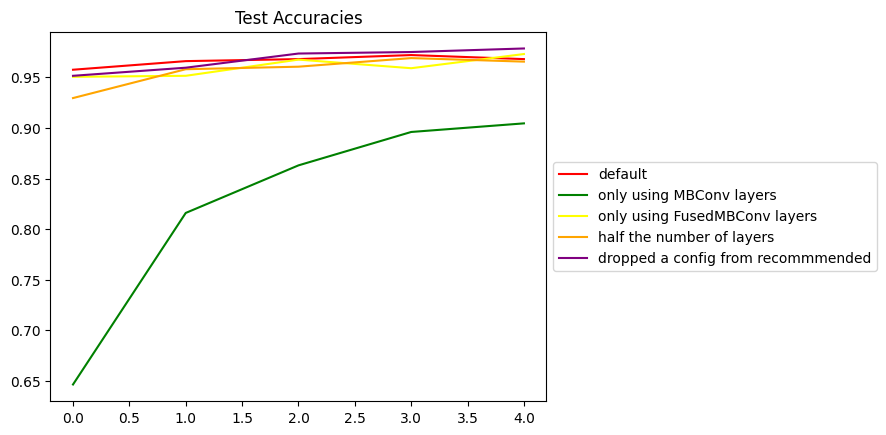

In [50]:
x = list(range(len(results[0]["test"])))

plt.plot(x, results[0]["test"], color='red', label='default')
plt.plot(x, results[1]["test"], color='green', label='only using MBConv layers')
plt.plot(x, results[2]["test"], color='yellow', label='only using FusedMBConv layers')
plt.plot(x, results[3]["test"], color='orange', label='half the number of layers')
plt.plot(x, results[4]["test"], color='purple', label='dropped a config from recommmended')

plt.title('Test Accuracies')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show the plot
plt.show()